In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from tqdm import tqdm, tqdm_notebook
from lvreml.data_prep import data_prep
from lvreml.lvreml import lvreml
from lvreml.initial_screen import initial_screen
from numpy.linalg import matrix_rank
import matplotlib.pyplot as plt

In [2]:
# Expression Data
expr_file = 'C:\\Users\\ammar\\Documents\\YeastFiles\\SI_Data_01_expressionValues.txt'
df_expr = pd.read_table(expr_file)
print('Expression Data Shape',df_expr.shape)

# Genotype Data
geno_file = 'C:\\Users\\ammar\\Documents\\YeastFiles\\genotypes_binary_strongest_eqtl.csv'
df_geno = pd.read_csv(geno_file, index_col=0)
print('Genotype Data Shape',df_geno.shape)

# Covariates Data
cov_file = 'C:\\Users\\ammar\\Documents\\YeastFiles\\SI_Data_02_covariates.csv'
df_cov = pd.read_csv(cov_file) # pd.read_excel()
print('Covariates Data Shape',df_cov.shape)

Expression Data Shape (1012, 5720)
Genotype Data Shape (1012, 2884)
Covariates Data Shape (1012, 3)


In [3]:
cov = df_cov.values[:,1:3].astype(float) # covariates 
data_expr = df_expr.values.astype(float) # expression values
expr_corr = np.empty_like(data_expr) # empty matrix for corrected expression values

X = pd.DataFrame(cov, columns=['Batch','OD'])
for i in tqdm(range(data_expr.shape[1])):
    y = pd.DataFrame(data_expr[:,i], columns=['expr'])
    df = pd.concat([X,y],axis=1)
    reg = smf.ols(formula="expr ~ OD + C(Batch)", data=df).fit()
    expr_corr[:,i] = reg.resid

100%|██████████████████████████████████████████████████████████████████████████████| 5720/5720 [01:14<00:00, 76.89it/s]


In [4]:
[Zn,S,V] = np.linalg.svd((df_geno.values - np.mean(df_geno.values, axis=0)),'econ')
vZ = (S**2)/np.sum(S**2)

In [5]:
C,_,Yn = data_prep(expr_corr,np.array([]))

C:\Users\ammar\Documents\GitHub\LVREML-Python\lvreml\data_prep.py:43: UserWarning: No covariates provided, assuming expression data is in format samples x genes
  warnings.warn("No covariates provided, assuming expression data is in format samples x genes")


In [6]:
beta2,varexpl,idx = initial_screen(C,Zn,0,verbose=False)
vx = np.flip(np.argsort(varexpl))

Text(0, 0.5, 'Gene expression variance explained')

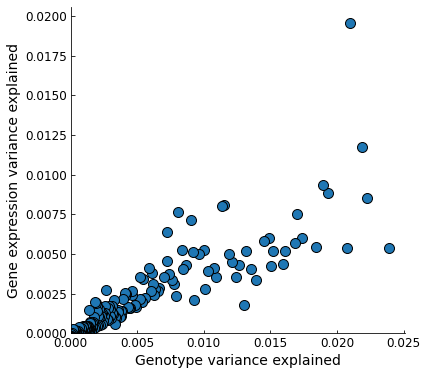

In [7]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(vZ,varexpl,'o', ms=10, mec='k')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim((0.00, None))
ax.set_ylim((0.00, None))
ax.tick_params(direction="in", labelsize=12)
ax.set_xlabel('Genotype variance explained', fontsize=14)
ax.set_ylabel('Gene expression variance explained', fontsize=14)

no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 
no covariates provided, only estimating hidden components using PCA 


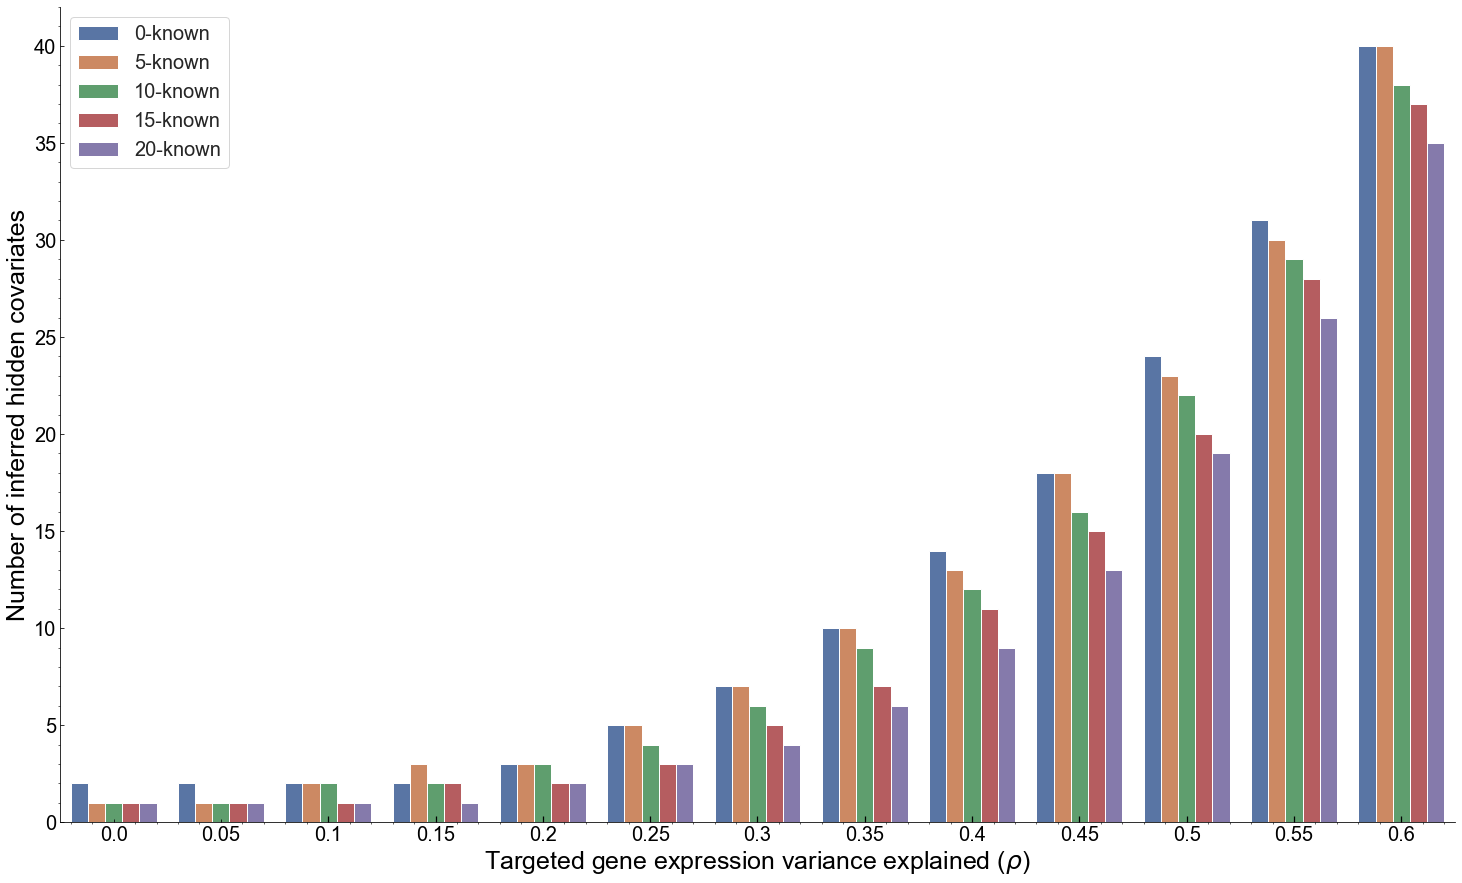

In [8]:
numcov =  np.arange(0,25,5)
rho = np.arange(0.0,0.65,0.05)
numX = np.zeros([len(rho),len(numcov)])
realVX = np.zeros([len(rho),len(numcov)])
numThet = np.zeros([len(rho),len(numcov)])
numRho = np.zeros([len(rho),len(numcov)])

for k in range(len(numcov)):
    
    Zk = np.array([])
    
    if k > 0:
        Zk = Zn[:,vx[0:numcov[k]]]
    
    for m in range(len(rho)):
        X,alpha2,B,D,sigma2,K = lvreml(C,Zk,rho[m])
        numX[m,k] = X.shape[1]
        numThet[m,k] = numcov[k]
        numRho[m,k] = rho[m]
        realVX[m,k] = (np.sum(np.diag(np.dot(np.dot(Zk,B),Zk.T))) + np.sum(np.diag(np.dot(np.dot(X,np.diag(alpha2)),X.T))))/np.sum(np.diag(C))
        
df1 = pd.DataFrame(numThet.flatten()) 
df2 = pd.DataFrame(numX.flatten())
df3 = pd.DataFrame(np.round(numRho,3).flatten())
df = pd.concat([df1, df2,df3], axis=1)
fig, ax = plt.subplots(figsize=(25,15))
labels = [x + '-known' for x in numcov.astype(str)]
sns.set(style="whitegrid")
df.columns = ['theta','hidden','rho']
ax = sns.barplot(x='rho', y='hidden', hue='theta', data=df)
#ax.tick_params(axis='both',labelsize='20')
ax.xaxis.label.set_fontsize(25)
ax.yaxis.label.set_fontsize(25)
#ax.set_title('Targeted gene expression variance explained ($\\rho$)', fontsize=25)
ax.set_xlabel('Targeted gene expression variance explained ($\\rho$)', fontsize=25)
ax.set_ylabel('Number of inferred hidden covariates', fontsize=25)
h, l = ax.get_legend_handles_labels()
ax.legend(h, labels, fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(direction="in", labelsize=20)
# plt.grid(which='major')
# plt.grid(which='minor')
plt.minorticks_on()

In [ ]:
def Likelihoodplots(C,Znall,Yn,theta,rho, flagC):
    THET = np.empty((len(theta),len(rho)))
    LL = np.empty((len(theta),len(rho)))
    HID = np.empty((len(theta),len(rho)))
    RHO = np.empty((len(theta),len(rho)))
    Ex,Vx = np.linalg.eigh(C)
    t = np.flip(np.argsort(Ex))
    Vx = Vx[:,t]
    plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
    col = ['-bo','--rx','-.ks',':go']
    
    for i in range(len(theta)):
        beta2,varexpl,idx = initial_screen(C,Znall,theta[i], verbose=False)
        if flagC == False:
            Z = Znall[:,idx]
        else:
            Z = Vx[:,0:theta[i]]

        for j in range(len(rho)):
            X,alpha2,B,D,sigma2,K = lvreml(C,Z,rho[j])   
            D, V = np.linalg.eigh(K)
            Dinv = np.diag(1/D)
            t1 = np.sum(np.log(D))
            t2 = np.trace(np.dot(np.dot(np.dot(V,Dinv),V.T),C))
            LL[i,j] = -(t1+t2)
            HID[i,j] = X.shape[1]
            THET[i,j] = theta[i]
            RHO[i,j] = rho[j]
        plt.plot(HID[i,:],LL[i,:],col[i])
    
    labels = [x + '-known' for x in theta.astype(str)]    
    plt.grid(which='major')
    plt.grid(which='minor')
    plt.minorticks_on()
    plt.ylabel('Log-likelihood value',fontsize=18)
    plt.xlabel('No. of Hidden confounders',fontsize=18)
    plt.xticks(rho,fontsize=10)
    plt.yticks(fontsize=15)
    plt.legend(labels, fontsize=15)

In [ ]:
theta =  np.array([0,5,10,20]) # No. of known factors
rho = np.arange(5,120,10) # No. of hidden factors
Likelihoodplots(C,Zn,Yn,theta,rho,flagC=True)